# Need optimization for AVISO and ERASTAR data load and interpolation

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import histlib.aviso as aviso
import histlib.cstes as cstes
from histlib.cstes import labels, zarr_dir

# Point de départ : colocalisations CMEMS altimetry + GDP drifters

## Exemple 1 dataset drifter_sat_year

In [2]:
l=labels[10]
ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')

/home1/datawork/gcaer/conda-env/histenv2/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home1/datawork/gcaer/conda-env/histenv2/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home1/datawork/gcaer/conda-env/histenv2/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home1/datawork/gcaer/conda-env/histenv2/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [4]:
ds_data

<xarray.Dataset>
Dimensions:                                       (obs: 164171, alti_time: 211,
                                                   alti_time_mid: 210,
                                                   box_y: 80, box_x: 120,
                                                   site_obs: 1489)
Coordinates: (12/20)
    alti_lat                                      (obs, alti_time) float64 dask.array<chunksize=(500, 211), meta=np.ndarray>
    alti_lon                                      (obs, alti_time) float64 dask.array<chunksize=(500, 211), meta=np.ndarray>
  * alti_time                                     (alti_time) int64 0 1 ... 210
    alti_time_                                    (obs, alti_time) datetime64[ns] dask.array<chunksize=(10261, 14), meta=np.ndarray>
  * alti_time_mid                                 (alti_time_mid) float64 0.5...
    alti_x                                        (obs, alti_time) float64 dask.array<chunksize=(500, 211), meta=np.ndarray>
    ...                                            ...
    drifter_x                                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    lat                                           (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                                           (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
  * obs                                           (obs) int64 0 1 ... 164170
    time                                          (obs) datetime64[ns] dask.array<chunksize=(41043,), meta=np.ndarray>
Dimensions without coordinates: site_obs
Data variables: (12/68)
    __site_id                                     (obs) object dask.array<chunksize=(41043,), meta=np.ndarray>
    __site_matchup_indice                         (obs) int32 dask.array<chunksize=(500,), meta=np.ndarray>
    __site_name                                   (obs) object dask.array<chunksize=(41043,), meta=np.ndarray>
    alti___distance                               (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti___source                                 (obs) object dask.array<chunksize=(41043,), meta=np.ndarray>
    alti___source_center_index                    (obs) object dask.array<chunksize=(41043,), meta=np.ndarray>
    ...                                            ...
    drifter_typedeath                             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_ve                                    (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vn                                    (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vx                                    (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vy                                    (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    f                                             (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    __id:                   CMEMS-L3-SLA-Jason-3__gps
    __time_coverage_end:    2020-01-01T00:00:00
    __time_coverage_start:  2019-01-01T00:00:00

## Nombre de colocalisations par fichier drifter_sat_year très différent

In [ ]:
S =[]
for l in labels :
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
    S.append(ds_data.dims['obs'])
df = pd.DataFrame({'drifter_sat_year':labels, 'nb':S}).set_index('drifter_sat_year')
fig = plt.figure(figsize=(20,4))
df.nb.plot.bar(color='teal')
plt.ylabel('Number of colocalizations')
plt.grid()

_____________
# Load AVISO around colocation and interpolate
    - AVISO = 1 fichier global par jour
    - load/ interpolations dans aviso.py, cherche 2 jours avant 2 jours après pour l'instant (5 jours en tout)
    
    - pour l'instant :
        - les fonctions sont lancées sur 100 000 colocalisation de 1 fichier drifter_sat_year à la fois
        dask_jobs = 10  # number of dask pbd jobs 
        jobqueuekw = dict(processes=20, cores=20)  # uplet debug
    - opération qui prend le plus de temps concat_aviso : 450 s
    -temps total calcul : 72h

In [6]:
aviso.compute_aviso_sla?

Signature: aviso.compute_aviso_sla(ds, dt=(-1, 2), only_matchup_time=True)
Docstring:
https://xarray.pydata.org/en/stable/user-guide/dask.html
Parameters
----------
ds: xr.Dataset
    Input colocalization dataset
dt: tuple
    Time offsets compared to the colocalization, e.g. if colocalization
    is at time t and dt=(-5,5), aviso data will be interpolated on
    the interval (t-5 days, t+5 days)
    Default is (-1,2)
only_matchup_time : bool
                    if True return aviso_sla, aviso_ggx/y on the box only for the drifter matchup time
                    if False return it for all aviso time over the dt period

Return
------
ds: xr.Dataset
    Dataset containing relevant aviso data
File:      ~/odatis/projects/historical_analysis/histlib/aviso.py
Type:      function

In [7]:
## Running functions
def run_aviso_divided(l, Ng=100000) :
    "run aviso on subfiles of constant obs dim (allow to always get same number of chunk/task, solve memory pb"
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
    ds_data = ds_data.where(ds_data.alti___distance<2e5, drop=True)#delete colocalization with alti_distance >200km (outside the box)
    Nt = ds_data.dims['obs']
    N=0
    i=0
    while N < Nt :
        if not os.path.isdir(os.path.join(zarr_dir, "aviso_"+l+f"_{i}.zarr")):
            ds_data_ = ds_data.isel(obs=slice(N,min(N+Ng, Nt))).chunk({'obs':500, 'alti_time':-1, 'site_obs':-1})
            run_aviso_divided_one(ds_data_, i)
        i+=1
        N+=Ng
            
def run_aviso_divided_one(ds_data, i):
    """run aviso on one subfile"""
    import dask.array as da
    ds_aviso = aviso.compute_aviso_sla(ds_data, dt=(-2,3), only_matchup_time = True).chunk({'obs':500, 'site_obs':-1})
    #store
    zarr = os.path.join(zarr_dir, "aviso_"+l+f"_{i}.zarr")
    ds_aviso.to_zarr(zarr, mode="w")  
    logging.info(f"aviso {l} group {i} storred in {zarr}")

## Exemple

In [7]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=20, processes=20, walltime='04:00:00')
    w = cluster.scale(jobs=10)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.64:8787/status,
Dashboard: http://10.148.1.64:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.64:47850,Workers: 0
Dashboard: http://10.148.1.64:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
%%time
N= 100 #CHANGE
ds_data_sub = ds_data.where(ds_data.alti___distance<2e5, drop=True).isel(obs=slice(N)).chunk({'obs':500, 'alti_time':-1, 'site_obs':-1})
ds_aviso = aviso.compute_aviso_sla(ds_data_sub, dt=(-2,3), only_matchup_time = True).chunk({'obs':500, 'site_obs':-1})

/home1/datawork/gcaer/conda-env/histenv2/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home1/datawork/gcaer/conda-env/histenv2/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home1/datawork/gcaer/conda-env/histenv2/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home1/datawork/gcaer/conda-env/histenv2/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home1/datawork/gcaer/conda-env/histenv2/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home1/d

<xarray.Dataset>
Dimensions:                        (obs: 2, site_obs: 1489, box_x: 120,
                                    box_y: 80, aviso_time: 5)
Coordinates:
  * obs                            (obs) int64 1 2
  * box_x                          (box_x) float64 -3e+05 -2.95e+05 ... 2.95e+05
  * box_y                          (box_y) float64 -2e+05 -1.95e+05 ... 1.95e+05
Dimensions without coordinates: site_obs, aviso_time
Data variables: (12/33)
    aviso_traj_sla                 (obs, site_obs) float64 nan nan ... nan nan
    aviso_traj_err_sla             (obs, site_obs) float64 nan nan ... nan nan
    aviso_traj_adt                 (obs, site_obs) float64 nan nan ... nan nan
    drifter_time                   (obs, site_obs) datetime64[ns] dask.array<chunksize=(1, 1489), meta=np.ndarray>
    drifter_x                      (obs, site_obs) float64 dask.array<chunksize=(1, 1489), meta=np.ndarray>
    drifter_y                      (obs, site_obs) float64 dask.array<chunksize=(1, 14

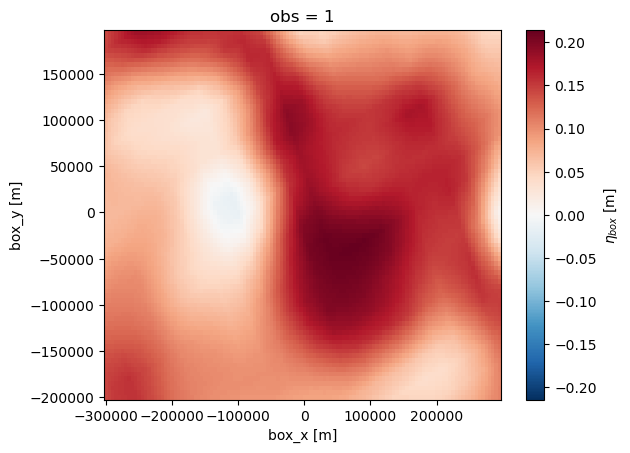

In [7]:
ds_aviso.isel(obs=0).aviso_box_sla.plot()

In [36]:
cluster.close()

NameError: name 'cluster' is not defined

_____________
# Load ERASTAR around colocation and interpolate
    - ERASTAR = 1 fichier global par HEURE
    - load/ interpolations dans erastar.py, cherche 2 jours avant 2 jours après pour l'instant (5 jours en tout)
    
    - pour l'instant :
        - les fonctions sont lancées sur 100 000 colocalisation de 1 fichier drifter_sat_year à la fois
        dask_jobs = 10  # number of dask pbd jobs 
        jobqueuekw = dict(processes=20, cores=20)  # uplet debug
    - opération qui prend le plus de temps concat_eras : 2h11
    -temps total calcul : 10-11 jours

In [32]:
eras.compute_eras?

Signature: eras.compute_eras(ds, dt, only_matchup_time=True)
Docstring:
https://xarray.pydata.org/en/stable/user-guide/dask.html
Parameters
----------
ds: xr.Dataset
    Input collocation dataset
dt: tuple
    Time offsets compared to the collocation, e.g. if collocation
    is at time t and dt=(-12,13), erastar data will be interpolated on
    the interval (t-12, t+12 hours) with an hour step
    Default is (-12,13)
only_matchup_time : bool
                    if True return stress on the box only for the drifter matchup time
                    if False return it for all erastar time over the dt period

Return
------
ds: xr.Dataset
    Dataset containing relevant aviso data
File:      ~/historical_analysis/histlib/erastar.py
Type:      function

In [ ]:
def run_eras_divided(l, Ng=100000) :
    "run erastar on subfiles of constant obs dim (allow to always get same number of chunk/task, solve memory pb"
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
    ds_data = ds_data.where(ds_data.alti___distance<2e5, drop=True)
    Nt = ds_data.dims['obs']
    N=0
    i=0
    while N < Nt :
        if not os.path.isdir(os.path.join(zarr_dir, "erastar_"+l+f"_{i}.zarr")):
            ds_data_ = ds_data.isel(obs=slice(N,min(N+Ng, Nt))).chunk({'obs':200, 'alti_time':-1, 'site_obs':-1})
            run_eras_divided_one(ds_data_, i)
        i+=1
        N+=Ng
            
def run_eras_divided_one(ds_data, i):
    """run erastar on one subfile"""
    import dask.array as da
    ds_es = eras.compute_eras(ds_data, dt=(-12,13), only_matchup_time = True).chunk({'obs':500, 'site_obs':-1}).persist()
    #store
    zarr = os.path.join(zarr_dir, "erastar_"+l+f"_{i}.zarr")
    ds_es.to_zarr(zarr, mode="w")  
    logging.info(f"erastar {l} group {i} storred in {zarr}")